In [ ]:
Based on Perplexity suggested workflow

1. Load required libraries

In [1]:
import pandas as pd

import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt

import sklearn
print(sklearn.__version__)

import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical

1.26.4
1.5.2


2024-12-03 01:37:04.697555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


2. Load and prepare the data

In [2]:
import os
from pathlib import Path

# Assuming your CSV files are in a 'data' directory relative to your script
data_dir = Path('csvdata')
print(data_dir)



csvdata


In [3]:
def load_data(ecg_file, labels_file):
    ecg_signal = pd.read_csv(ecg_file, header=None).values.flatten()
    labels = pd.read_csv(labels_file)
    return ecg_signal, labels

def create_mask(ecg_signal, labels):
    mask = np.zeros(len(ecg_signal), dtype=int)
    for _, row in labels.iterrows():
        start, end = row['ROILimits_1'], row['ROILimits_2']
        value = row['Value']
        mask[start:end] = ['P', 'QRS', 'T'].index(value) + 1
    return mask

def resize_data(ecg_signal, mask, segment_length=5000):
    num_segments = len(ecg_signal) // segment_length
    ecg_segments = np.array_split(ecg_signal[:num_segments*segment_length], num_segments)
    mask_segments = np.array_split(mask[:num_segments*segment_length], num_segments)
    return np.array(ecg_segments), np.array(mask_segments)

# Passing very long input signals into the LSTM network can result in estimation performance degradation and excessive memory usage. 
# To avoid these effects, break the ECG signals and their corresponding label masks.
# create as many 5000-sample segments as possible and discard the remaining samples. 

# Load and process all files
    
# Initialize empty lists:    
all_ecg_segments = []
all_mask_segments = []
#These lists will store the processed ECG segments and their corresponding masks.

for i in range(1, 211):  # Assuming 210 files
    ecg_file = data_dir / f'ecg{i}_ecgSignal.csv'
    labels_file = data_dir / f'ecg{i}_signalRegionLabels.csv'
    
    ecg_signal, labels = load_data(ecg_file, labels_file)
    mask = create_mask(ecg_signal, labels)
    ecg_segments, mask_segments = resize_data(ecg_signal, mask)
    
    all_ecg_segments.extend(ecg_segments)  
    all_mask_segments.extend(mask_segments)

# The processed segments are added to the respective lists.

# Convert to numpy arrays:
X = np.array(all_ecg_segments)
y = np.array(all_mask_segments)


Visualise the numpy arrays

In [5]:
import matplotlib.pyplot as plt

def plot_ecg_and_mask(ecg_segment, mask_segment, index):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot ECG signal
    ax1.plot(ecg_segment)
    ax1.set_title(f'ECG Segment {index}')
    ax1.set_ylabel('Amplitude')
    
    # Plot mask
    ax2.plot(mask_segment)
    ax2.set_title(f'Mask Segment {index}')
    ax2.set_ylabel('Label')
    ax2.set_ylim(-0.5, 3.5)
    ax2.set_yticks([0, 1, 2, 3])
    ax2.set_yticklabels(['Background', 'P', 'QRS', 'T'])
    
    plt.xlabel('Sample')
    plt.tight_layout()
    plt.show()


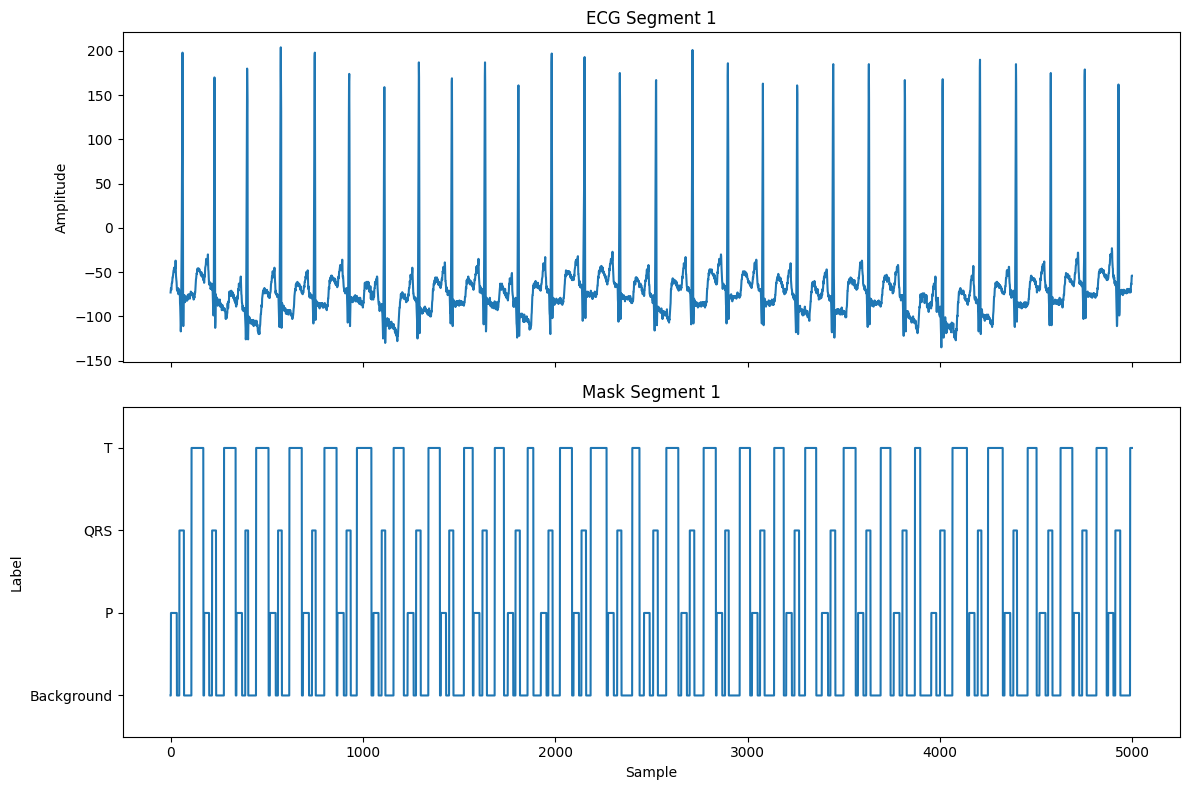

In [6]:
plot_ecg_and_mask(X[1],y[1],1)

Visualize a few random samples:

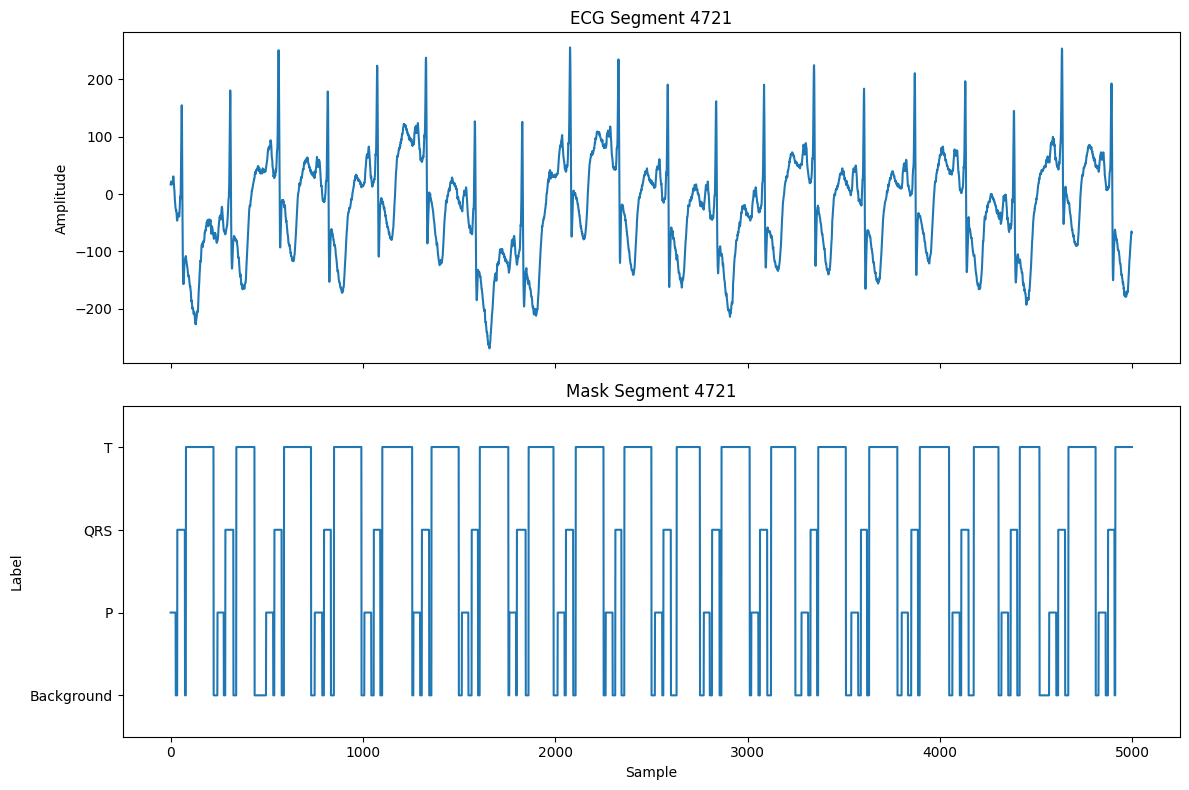

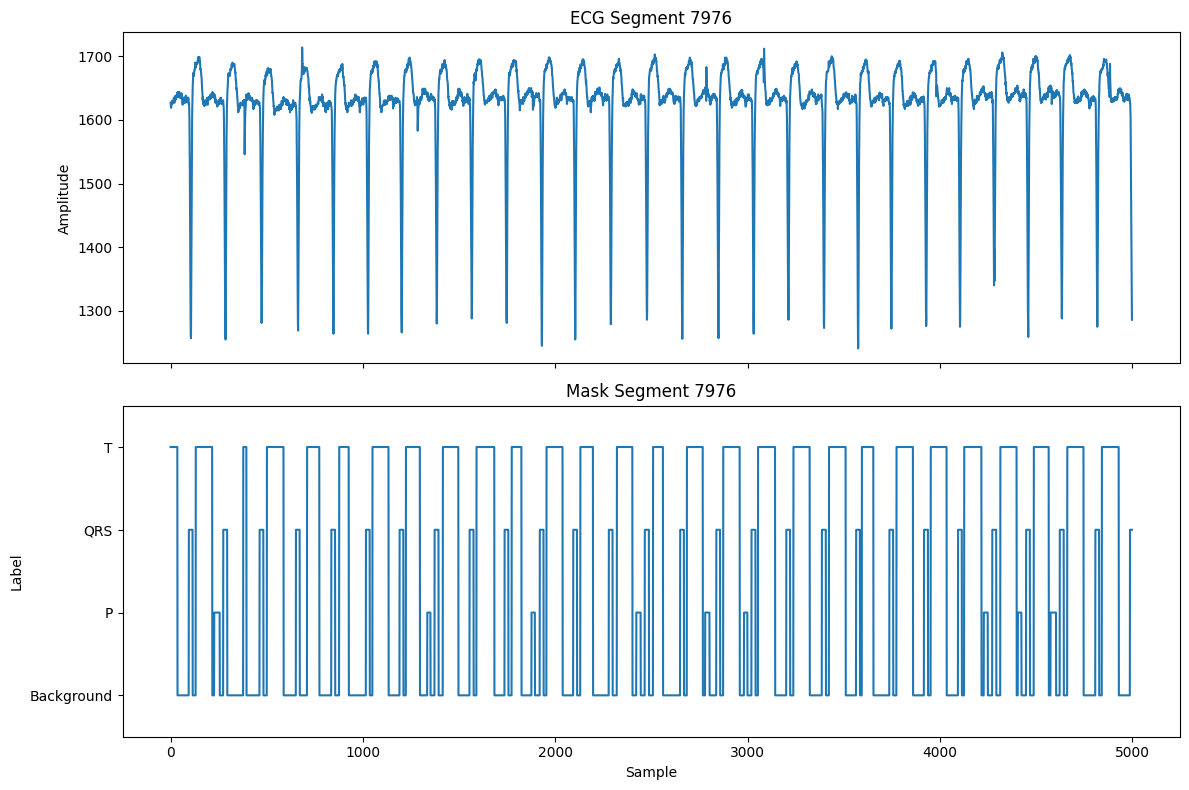

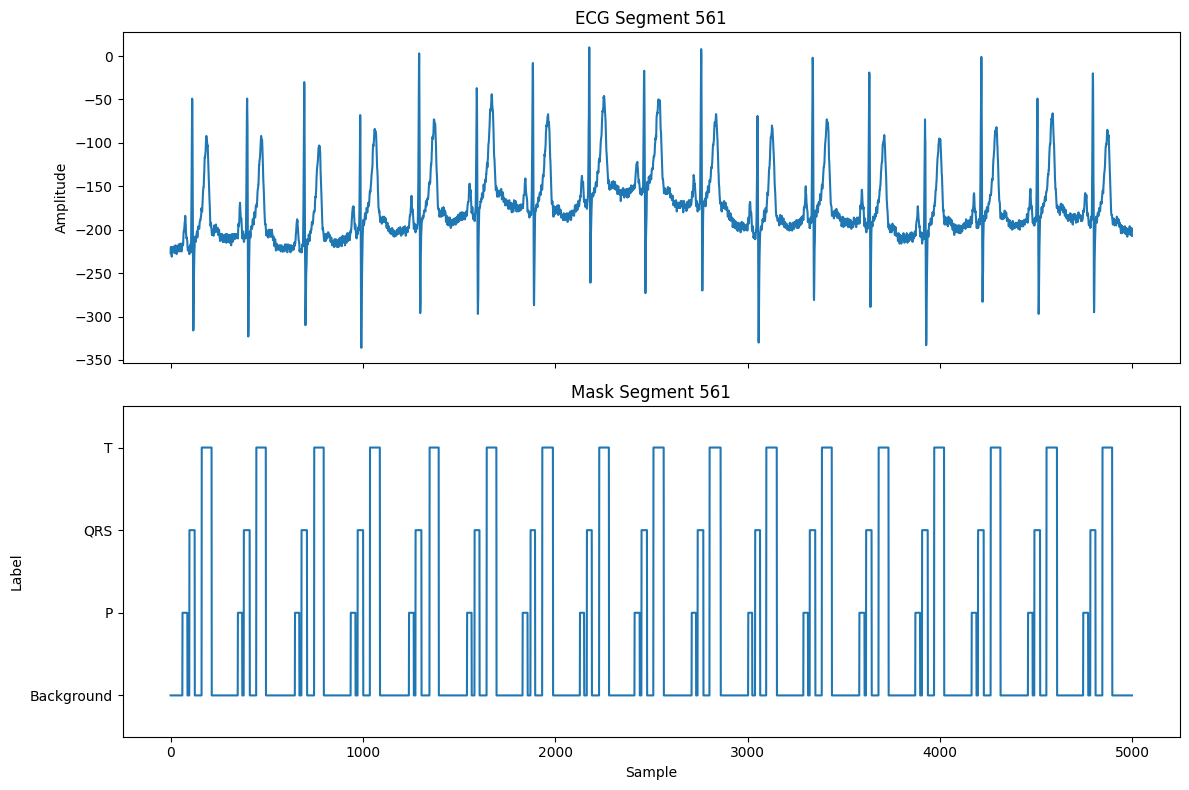

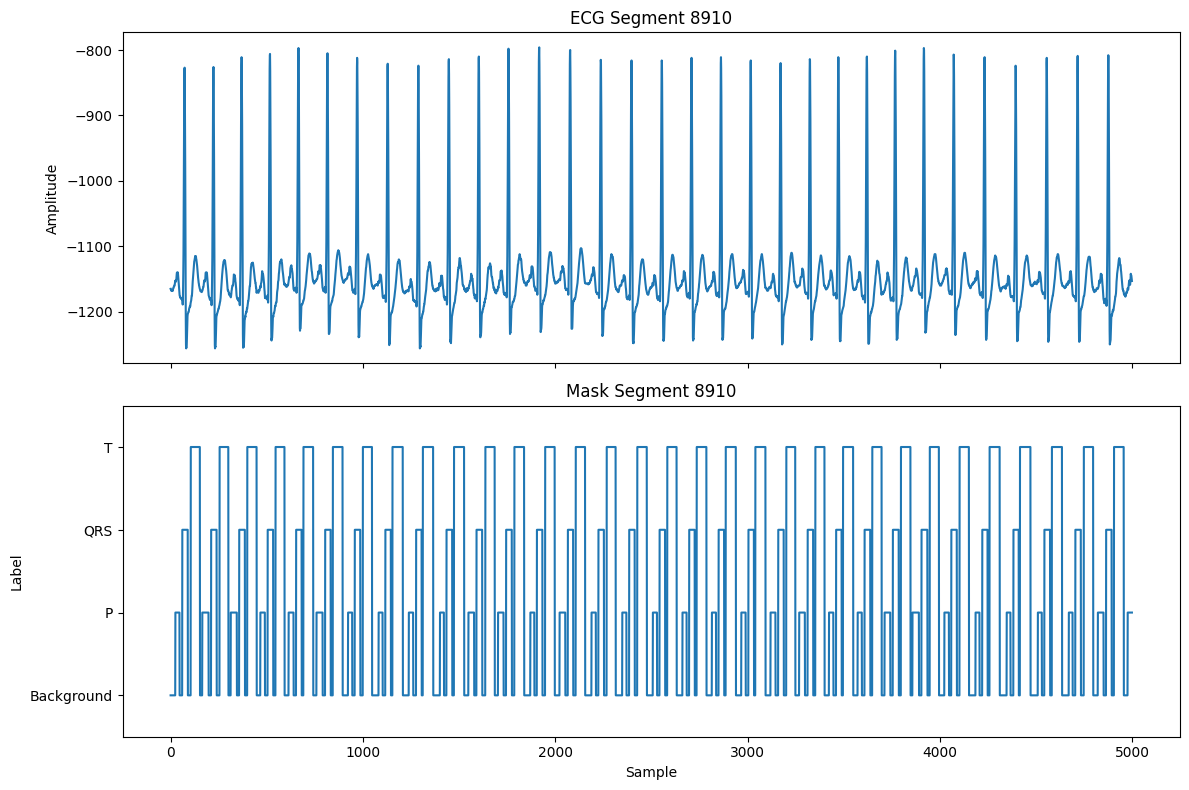

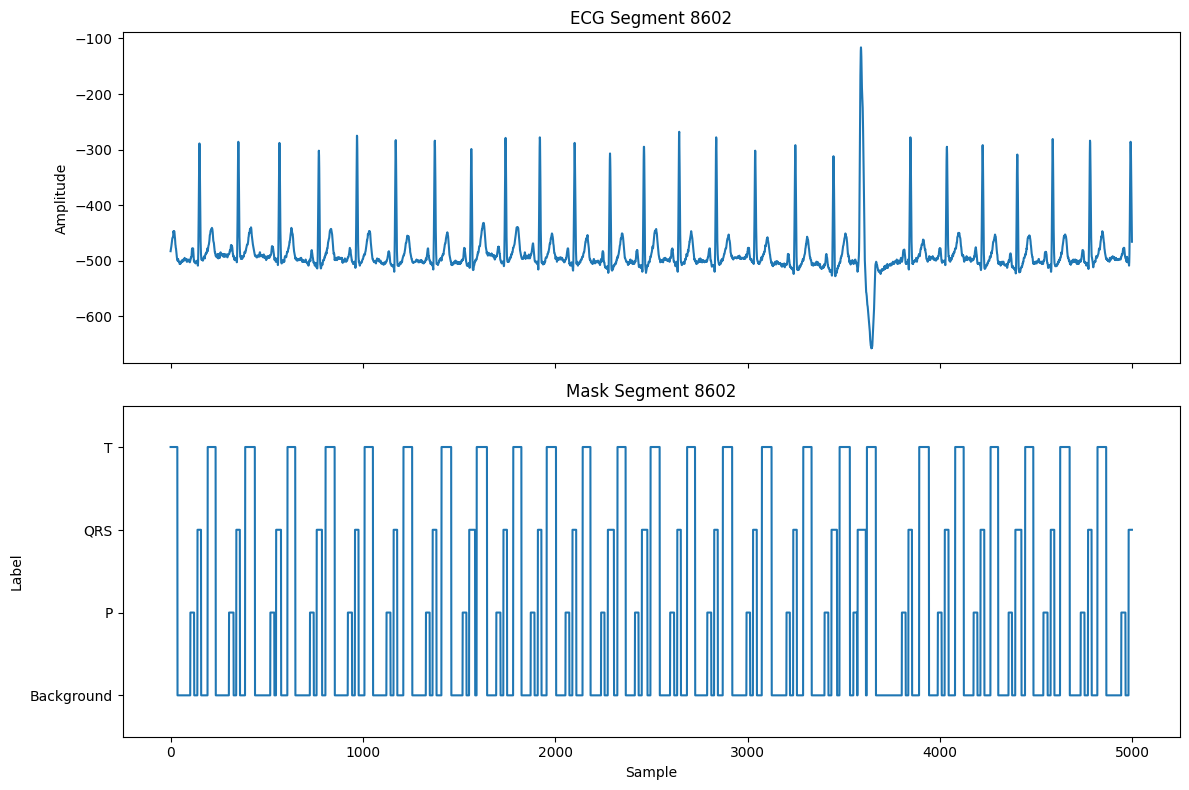

In [13]:
num_samples = 5
random_indices = np.random.choice(X.shape[0], num_samples, replace=False)

for i, idx in enumerate(random_indices):
    plot_ecg_and_mask(X[idx], y[idx], idx)


3. Split the data into training and testing sets

test_size=0.3: This parameter specifies that 30% of the data should be allocated to the test set, while the remaining 70% will be used for training

random_state=42: This parameter sets a seed for the random number generator, ensuring that the split is reproducible. Using the same random_state will always produce the same split, which is crucial for reproducibility in machine learning experiments

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


4. Prepare the data for LSTM

## one-hot encoding for categorical labels
One-hot encoding is a technique used to convert categorical variables into a format suitable for machine learning algorithms. It transforms categorical data into a binary representation, allowing models to process and interpret non-numeric information effectively.
How One-Hot Encoding Works
The process of one-hot encoding involves the following steps:
	1.	Identify unique categories within a categorical variable.
	2.	Create new binary columns, one for each unique category.
	3.	For each data point, assign a value of 1 in the column corresponding to its category and 0 in all other columns.

In [8]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)



In [9]:
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)


X_train shape: (6542, 5000)
y_train_cat shape: (6542, 5000, 4)


5. Create and compile the LSTM model
This code defines and compiles a neural network model using Keras for a multiclass classification task. 

Model 1: Bidirectional LSTM
OR
Model 2: CNN (Convolutional Neural Network)

These two models are quite different in their architecture and approach to processing sequential data. Let’s compare them:
Model 1: Bidirectional LSTM
This model uses Bidirectional Long Short-Term Memory (LSTM) layers.
Key Features:
	1.	Bidirectional LSTM Layers: Processes sequences in both forward and backward directions, capturing context from both past and future states.
	2.	Sequential Processing: Designed to handle long-term dependencies in sequential data.
	3.	No Explicit Feature Extraction: LSTMs learn to extract relevant features from the raw sequence data.
Suitable for:
	•	Natural Language Processing tasks
	•	Time series analysis where long-term dependencies are crucial
	•	Tasks requiring understanding of context in both directions of a sequence

Model 2: CNN (Convolutional Neural Network)
This model uses Convolutional and Pooling layers, typically associated with image processing but adapted for sequence data.
Key Features:
	1.	Convolutional Layers: Extract local patterns or features from the input sequence.
	2.	MaxPooling Layers: Reduce dimensionality and capture the most important features.
	3.	Dropout Layers: Help prevent overfitting by randomly deactivating neurons during training.
	4.	Flatten Layer: Converts the 2D feature maps to a 1D vector for the dense layers.
	5.	Dense Layers: Make the final classification based on the extracted features.
Suitable for:
	•	Tasks where local patterns in the sequence are important
	•	Scenarios where the relative position of features matters more than long-term dependencies
	•	Often used in text classification, especially for shorter sequences

Key Differences
	1.	Approach to Feature Extraction:
	•	Model 1 relies on LSTM to learn temporal dependencies.
	•	Model 2 uses convolutions to extract local patterns.
	2.	Handling of Sequence Length:
	•	Model 1 can handle variable-length sequences more naturally.
	•	Model 2 typically requires fixed-length input (defined by `window_size`).
	3.	Complexity and Parameters:
	•	Model 1 likely has fewer parameters but may be more computationally intensive.
	•	Model 2 might be faster to train but could have more parameters depending on the configuration.
	4.	Context Understanding:
	•	Model 1 is better at capturing long-range dependencies.
	•	Model 2 excels at identifying local patterns and their relative positions.
	5.	Regularization:
	•	Model 2 explicitly uses Dropout for regularization.
	•	Model 1 relies on the inherent properties of LSTM for managing overfitting.
In summary, Model 1 is more suited for tasks requiring understanding of long-term dependencies and bidirectional context, while Model 2 is better for tasks where local patterns and their relative positions are more important. The choice between them would depend on the specific characteristics of your data and the nature of the problem you’re trying to solve.

The model is compiled with the following settings:
	•	Optimizer: Adam optimizer is used, which is an adaptive learning rate optimization algorithm.
	•	Loss Function: Categorical crossentropy, suitable for multiclass classification problems.
	•	Metric: Accuracy, which measures the overall correctness of the model’s predictions

5.1 Bidirectional LSTM model 1:

Selection of Layer Sizes
	1.	64 units in the first LSTM layer:
	•	This is likely chosen to capture a rich set of features from the input sequence.
	•	A larger number allows for more complex pattern recognition.
	2.	32 units in the second LSTM layer:
	•	Reduction in units helps in distilling the most important features.
	•	It’s common to reduce the number of units in deeper layers to prevent overfitting.
	3.	5 neurons in the output layer:
	•	This directly corresponds to the number of classes in the classification task.
	•	Each neuron represents the probability of the input belonging to one of the 5 classes.

In [10]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Input

model = Sequential([
    Input(shape=(5000, 1)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



6. Train the model
Key Components
	1.	model.fit(): This is the Keras method used to train the model on data.
	2.	X_train: The input training data. This typically contains the features or sequences the model will learn from.
	3.	y_train_cat: The target labels for the training data. The ‘_cat’ suffix suggests these are categorical (one-hot encoded) labels.
	4.	validation_split=0.2: This parameter sets aside 20% of the training data for validation. The model won’t train on this data but will use it to evaluate performance after each epoch.
	5.	epochs=10: The number of times the model will iterate over the entire training dataset. Here, it’s set to 10 complete passes.
	6.	batch_size=32: This defines how many samples the model will process before updating its internal parameters. A batch size of 32 is a common choice, balancing between computational efficiency and model update frequency.
	7.	history: The variable that stores the output of the training process. It contains information about the training metrics (like loss and accuracy) for each epoch.

In [11]:
history = model.fit(X_train, y_train_cat, validation_split=0.2, epochs=2, batch_size=32)


Epoch 1/2
164/164 ━━━━━━━━━━━━━━━━━━━━ 1257s 8s/step - accuracy: 0.5909 - loss: 1.0031 - val_accuracy: 0.7262 - val_loss: 0.6885
Epoch 2/2
164/164 ━━━━━━━━━━━━━━━━━━━━ 944s 6s/step - accuracy: 0.7367 - loss: 0.6626 - val_accuracy: 0.7517 - val_loss: 0.6208


Evaluate the model

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7561 - loss: 0.6106
Test accuracy: 0.7534


In [13]:
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)



Input shape: (None, 5000, 1)
Output shape: (None, 5000, 4)


Make predictions and visualize results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


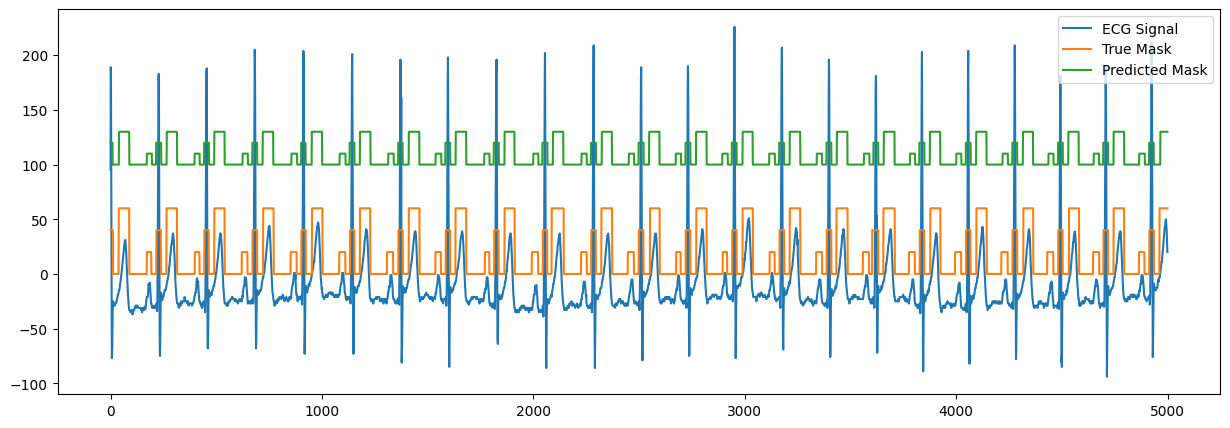

In [19]:
def plot_results(ecg_segment, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.plot(true_mask * 20, label='True Mask')
    plt.plot(predicted_mask * 10+100, label='Predicted Mask')
    plt.legend()
    plt.show()

# Make predictions on a test sample
sample_index = 4 #identifies which sample to test
sample_ecg = X_test[sample_index]
sample_true_mask = y_test[sample_index]
sample_predicted_mask = model.predict(sample_ecg.reshape(1, 5000, 1))[0]
sample_predicted_mask = np.argmax(sample_predicted_mask, axis=1)

plot_results(sample_ecg, sample_true_mask, sample_predicted_mask)


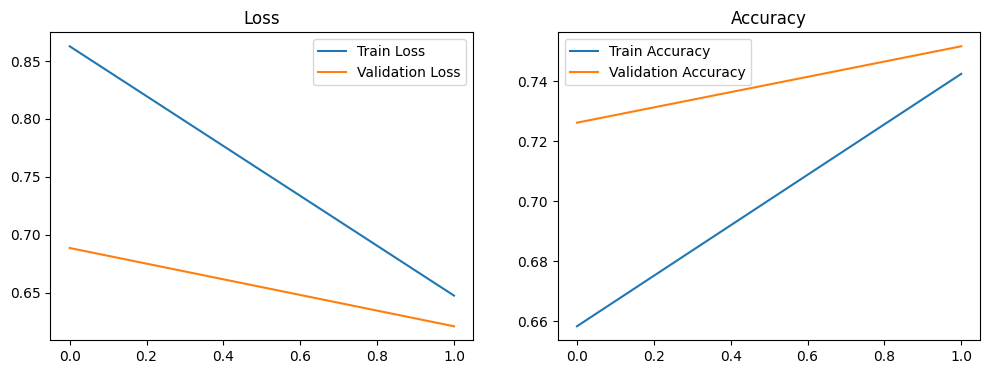

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [17]:
print(type(y_train))
print(y_train.ndim)
print(y_train[:5])

<class 'numpy.ndarray'>
2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 [0 0 0 ... 2 2 2]]
